In [1]:
%%capture
!pip install fairlearn

In [2]:
#@markdown Load modules
import numpy as np
from IPython.display import display, Markdown, Latex
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.adversarial import AdversarialFairnessClassifier
from fairlearn.metrics import MetricFrame
import fairlearn.datasets as fdata
from fairlearn.metrics import (demographic_parity_difference, demographic_parity_ratio,
                               selection_rate_difference, false_negative_rate_difference,
                               false_positive_rate_difference, equalized_odds_ratio,
                               false_negative_rate, false_positive_rate)

# Load and preprocess the data

In [3]:
#@markdown Load and read about the dataset.
# get datast from fairlearn and show description
dataset = fdata.fetch_diabetes_hospital()

display(Markdown(dataset.DESCR))

# save dataframe and features
x_raw = dataset.data
# y_raw = np.array(dataset.target)
feature_names = dataset.feature_names

The "Diabetes 130-Hospitals" dataset represents 10 years of clinical care at 130 U.S. hospitals and delivery networks, collected from 1999 to 2008. Each record represents the hospital admission record for a patient diagnosed with diabetes whose stay lasted between one to fourteen days. The features describing each encounter include demographics, diagnoses, diabetic medications, number of visits in the year preceding the encounter, and payer information, as well as whether the patient was readmitted after release, and whether the readmission occurred within 30 days of the release.

The original "Diabetes 130-Hospitals" dataset was collected by Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore in 2014.

This version of the dataset was derived by the Fairlearn team for the SciPy 2021 tutorial "Fairness in AI Systems: From social context to practice using Fairlearn". In this version, the target variable "readmitted" is binarized into whether the patient was re-admitted within thirty days. The full dataset pre-processing script can be found on GitHub: https://github.com/fairlearn/talks/blob/main/2021_scipy_tutorial/preprocess.py

Downloaded from openml.org.

You can read more about the dataset [here](https://fairlearn.org/main/user_guide/datasets/diabetes_hospital_data.html). In this description, we see that two features, `readmitted` and `readmit_binary`, are other representations of the same outcome, so we drop them from the set of predictors.

In [4]:
#@markdown Down sample to make runtimes reasonable
x_raw = x_raw.sample(frac=0.1, random_state=123)

In [5]:
y_raw = x_raw['readmit_binary']
x_raw = x_raw.drop(columns=['readmitted', 'readmit_binary'])
feature_names = feature_names[:-2]

In [6]:
#@markdown Look at the first few rows of the data.
x_raw.head()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,max_glu_serum,A1Cresult,insulin,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days
65884,Caucasian,Male,'Over 60 years','Discharged to Home',Emergency,3,Missing,49,6,27,...,None,None,Up,Ch,Yes,False,False,False,True,False
86278,Caucasian,Female,'Over 60 years',Other,Referral,5,Missing,57,0,21,...,None,None,No,Ch,Yes,True,False,False,True,False
30000,Caucasian,Male,'30-60 years','Discharged to Home',Other,4,Other,37,2,9,...,None,None,No,No,No,False,False,False,False,False
51185,Caucasian,Male,'30-60 years',Other,Other,9,InternalMedicine,61,6,27,...,None,>8,No,Ch,Yes,False,False,True,False,True
53902,Caucasian,Female,'30-60 years','Discharged to Home',Referral,7,Other,23,0,13,...,None,None,No,No,Yes,True,False,True,True,False


## data inspectation

In [7]:
#@markdown drop the rows with 'Unknown/Invalid' values for gender

# drop these 3 rows
print(x_raw.shape)
rows_to_keep = x_raw.gender != 'Unknown/Invalid'
x_raw = x_raw[rows_to_keep]
y_raw = y_raw[rows_to_keep]
print(x_raw.shape)

(10177, 22)
(10177, 22)


In [8]:
#@markdown
unique_feature_values = x_raw.apply(np.unique, axis=0)
unique_feature_values

,0
race,"[AfricanAmerican, Asian, Caucasian, Hispanic, ..."
gender,"[Female, Male]"
age,"['30 years or younger', '30-60 years', 'Over 6..."
discharge_disposition_id,"['Discharged to Home', Other]"
admission_source_id,"[Emergency, Other, Referral]"
time_in_hospital,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]"
medical_specialty,"[Cardiology, Emergency/Trauma, Family/GeneralP..."
num_lab_procedures,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
num_procedures,"[0, 1, 2, 3, 4, 5, 6]"
num_medications,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [9]:
#@markdown
binary_features = unique_feature_values.index[[len(x) == 2 for x in unique_feature_values]].values
print(f'Binary features: {binary_features}')
categorical_features = unique_feature_values.index[[len(x) > 2 and isinstance(x[0], str) for x in unique_feature_values]].values
print(f'Categorical features: {categorical_features}')

Binary features: ['gender' 'discharge_disposition_id' 'change' 'diabetesMed' 'medicare'
 'medicaid' 'had_emergency' 'had_inpatient_days' 'had_outpatient_days']
Categorical features: ['race' 'age' 'admission_source_id' 'medical_specialty'
 'primary_diagnosis' 'max_glu_serum' 'A1Cresult' 'insulin']


In [10]:
#@markdown standardize data types
for col_name in feature_names:
    if col_name in categorical_features:
        x_raw[col_name] = x_raw[col_name].astype('category')
    elif col_name in binary_features:  # redundant for clarity
        # turn into int column
        integer_col = (x_raw[col_name] == unique_feature_values[col_name][0]).astype(int)
        new_name = f'{col_name}_{unique_feature_values[col_name][0]}'
        x_raw[new_name] = integer_col
        x_raw.drop(columns=[col_name], inplace=True)

In [11]:
#@markdown
%%capture
x_raw.apply(np.unique, axis=0)

In [12]:
x_raw.dtypes

,0
race,category
age,category
admission_source_id,category
time_in_hospital,int64
medical_specialty,category
num_lab_procedures,int64
num_procedures,int64
num_medications,int64
primary_diagnosis,category
number_diagnoses,int64


In [13]:
#@markdown One-hot encode categorical features
x_numeric = pd.get_dummies(x_raw)
display(x_numeric.head())

# get one-hot and numeric column names
numeric_cols = x_numeric.dtypes.index[x_numeric.dtypes == 'int64'].values
one_hot_cols = x_numeric.dtypes.index[x_numeric.dtypes != 'int64'].values

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,gender_Female,discharge_disposition_id_'Discharged to Home',change_Ch,diabetesMed_No,medicare_False,...,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up
65884,3,49,6,27,9,0,1,1,0,1,...,True,False,False,False,True,False,False,False,False,True
86278,5,57,0,21,9,1,0,1,0,0,...,True,False,False,False,True,False,False,True,False,False
30000,4,37,2,9,5,0,1,0,1,1,...,True,False,False,False,True,False,False,True,False,False
51185,9,61,6,27,9,0,0,1,0,1,...,True,False,False,True,False,False,False,True,False,False
53902,7,23,0,13,7,1,1,0,0,0,...,True,False,False,False,True,False,False,True,False,False


 # TODO: Split train, test data 80 train / 20 test


In [15]:
# write your code here

# defining dataframe to do train test split on
# Define the features (X) and target variable (y)

sensitive_feature = x_raw['gender_Female']

# removing the one-hot encoding columns for gender from the model to prevent the model from using gender information directly
sensitive_columns = [col for col in x_numeric.columns if col.startswith('gender_')]
x_features = x_numeric.drop(columns=sensitive_columns)

# now performing train test split

# splitting features, target, and sensitive attributes together to keep the same alignment
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    x_features, y_raw, sensitive_feature, test_size=0.2, random_state=123)

# Problem 2, Part (a)
### **Train a baseline Random Forest (RF) (sklearn RandomForestClassifier) model and report metrics**

### Train a random forest model - Baseline

In [16]:
# write your code here
# initialize a model with RandomForestClassifier

# train the model with the training data split

# initialize the Random Forest Classifier
rf_baseline = RandomForestClassifier(n_estimators=1)

# training the model with the training data split
rf_baseline.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1)

### Report metrics

Calculate metrics with Fairlearn MetricFrame


In [17]:
# write your code here

# get model's prediction for the test set
y_pred_baseline = rf_baseline.predict(X_test)

# use MetricFrame to get the results
metric_dict = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "FNR": false_negative_rate,
    "FPR": false_positive_rate
}

sample_params = {}

# creating a MetricFrame to evaluate metrics by sensitive features and overall performance
metric_frame = MetricFrame(
    metrics=metric_dict,
    y_true=y_test,
    y_pred=y_pred_baseline,
    sensitive_features=sensitive_test,
    sample_params=sample_params
)

Print Results

In [20]:
print("Overall Baseline Model Performance Metrics:")
display(metric_frame.overall)

print("\nPerformance Metrics By Group:")
display(metric_frame.by_group)

Overall Baseline Model Performance Metrics:


,0
Accuracy,0.531434
Precision,0.488959
Recall,0.498392
FNR,0.501608
FPR,0.440617



Performance Metrics By Group:


,Accuracy,Precision,Recall,FNR,FPR
gender_Female,,,,,
0,0.526198,0.460000,0.468193,0.531807,0.428571
1,0.535558,0.509982,0.520370,0.479630,0.450751


# Problem 2, Part (b)

Train another classifier with the following value of hyperparameters

In [21]:
# write your code here

rf_tuned = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=123)

rf_tuned.fit(X_train, y_train)

y_pred_tuned = rf_tuned.predict(X_test)

Calculate metrics with Fairlearn MetricFrame
and print the results

In [23]:
metric_dict = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "FNR": false_negative_rate,
    "FPR": false_positive_rate
}
sample_params = {}
metric_frame_tuned = MetricFrame(
    metrics=metric_dict,
    y_true=y_test,
    y_pred=y_pred_tuned,
    sensitive_features=sensitive_test,
    sample_params=sample_params
)

# printing results
print("Tuned Classifier Overall Performance Metrics:")
display(metric_frame_tuned.overall)

print("\nTuned Classifier Performance Metrics By Group:")
display(metric_frame_tuned.by_group)

Tuned Classifier Overall Performance Metrics:


,0
Accuracy,0.622790
Precision,0.611940
Recall,0.483387
FNR,0.516613
FPR,0.259293



Tuned Classifier Performance Metrics By Group:


,Accuracy,Precision,Recall,FNR,FPR
gender_Female,,,,,
0,0.619844,0.585526,0.452926,0.547074,0.250000
1,0.625110,0.630485,0.505556,0.494444,0.267112


# Problem 2, Part (c)
### **Fit Fairlean Adversarial Debiaser**

Experiment with the alpha parameter - which value of alpha produces the fairest and most accurate classifier? Does such a value exist?

In [24]:
#@markdown Fit the AdversarialFairnessClassifier here.
#@markdown Use these hyperparameters, while varying the `alpha` parameter:
#@markdown - backend='tensorflow',
#@markdown - predictor_model=[128,64,32,16,8],
#@markdown - adversary_model=[32,16,8],
#@markdown - learning_rate=0.001,
#@markdown - epochs=3,
#@markdown - batch_size=16,
#@markdown - constraints='demographic_parity',
#@markdown - random_state=seed,
#@markdown - shuffle=True

alpha_values = [0.0, 0.3, 0.7, 1.0]
seeds = range(10)
results = []

for alpha in alpha_values:
    for seed in seeds:
        print(f"Training Adversarial Fairnes sClassifier with alpha={alpha} and seed={seed}")
        afc_classifier = AdversarialFairnessClassifier(
            backend='tensorflow',
            predictor_model=[128,64,32,16,8],
            adversary_model=[32,16,8],
            learning_rate=0.001,
            epochs=3,
            batch_size=16,
            constraints='demographic_parity',
            random_state=seed,
            shuffle=True,
            alpha=alpha
        )

        afc_classifier.fit(X_train, y_train, sensitive_features=sensitive_train)

        y_pred = afc_classifier.predict(X_test)

        metric_dict = {
            "Accuracy": accuracy_score,
            "Precision": precision_score,
            "Recall": recall_score,
            "FNR": false_negative_rate,
            "FPR": false_positive_rate
        }

        metric_frame_new = MetricFrame(
            metrics=metric_dict,
            y_true=y_test,
            y_pred=y_pred,
            sensitive_features=sensitive_test
        )

        # storing results in the form of (alpha, seed)
        results.append({
            "Alpha": alpha,
            "Seed": seed,
            "Accuracy": metric_frame_new.overall["Accuracy"],
            "Precision": metric_frame_new.overall["Precision"],
            "Recall": metric_frame_new.overall["Recall"],
            "FNR": metric_frame_new.overall["FNR"],
            "FPR": metric_frame_new.overall["FPR"]
        })

# converting to dataframe for plotting
results_df = pd.DataFrame(results)
print(results_df.head())



Training Adversarial Fairnes sClassifier with alpha=0.0 and seed=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.0 and seed=1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.0 and seed=2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.0 and seed=3


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.0 and seed=4


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.0 and seed=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.0 and seed=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.0 and seed=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.0 and seed=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.0 and seed=9


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.3 and seed=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.3 and seed=1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.3 and seed=2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.3 and seed=3


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.3 and seed=4


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.3 and seed=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.3 and seed=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.3 and seed=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.3 and seed=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.3 and seed=9


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.7 and seed=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.7 and seed=1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.7 and seed=2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.7 and seed=3


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.7 and seed=4


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.7 and seed=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.7 and seed=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.7 and seed=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.7 and seed=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=0.7 and seed=9


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=1.0 and seed=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=1.0 and seed=1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=1.0 and seed=2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=1.0 and seed=3


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=1.0 and seed=4


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=1.0 and seed=5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=1.0 and seed=6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=1.0 and seed=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=1.0 and seed=8


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


Training Adversarial Fairnes sClassifier with alpha=1.0 and seed=9
   Alpha  Seed  Accuracy  Precision    Recall       FNR       FPR
0    0.0     0  0.600196   0.618762  0.332262  0.667738  0.173164
1    0.0     1  0.559921   0.648000  0.086817  0.913183  0.039891
2    0.0     2  0.567289   0.518598  0.777063  0.222937  0.610154
3    0.0     3  0.564833   0.515911  0.816720  0.183280  0.648232
4    0.0     4  0.500491   0.476055  0.894962  0.105038  0.833182


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessClassifier was fitted without feature names
  warnings.warn(


<ipython-input-31-9d20518d4fad>:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax.boxplot(alpha_data, labels=alpha_values, patch_artist=True)
<ipython-input-31-9d20518d4fad>:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax.boxplot(alpha_data, labels=alpha_values, patch_artist=True)
<ipython-input-31-9d20518d4fad>:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax.boxplot(alpha_data, labels=alpha_values, patch_artist=True)
<ipython-input-31-9d20518d4fad>:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; su

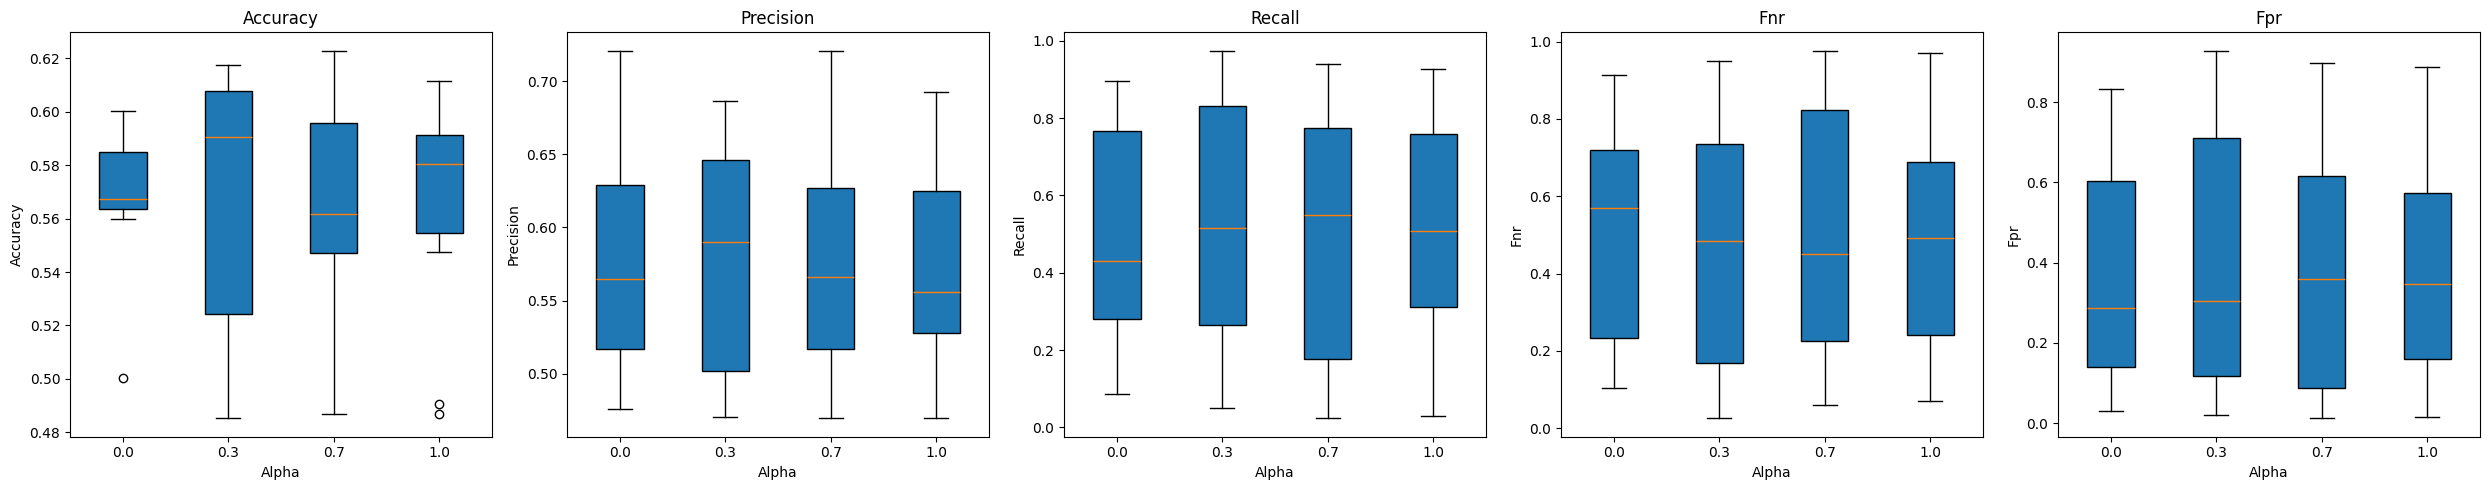

In [31]:
#@markdown ### Plot all our metrics as line plots while varying alpha

plotting_metrics = ["Accuracy", "Precision", "Recall", "FNR", "FPR"]

fig, axs = plt.subplots(1, len(plotting_metrics), figsize=(5 * len(plotting_metrics), 5))
for i, metric in enumerate(plotting_metrics):
    ax = axs[i]
    # Gather the results for each alpha value.
    alpha_data = [results_df.loc[results_df["Alpha"] == alpha, metric] for alpha in alpha_values]
    box_plot = ax.boxplot(alpha_data, labels=alpha_values, patch_artist=True)
    ax.set_title(metric.capitalize())
    ax.set_xlabel("Alpha")
    ax.set_ylabel(metric.capitalize())

plt.tight_layout()
plt.show()


# Problem 2, Part (d)
### **Threshold Optimizer Post-processing intervention**



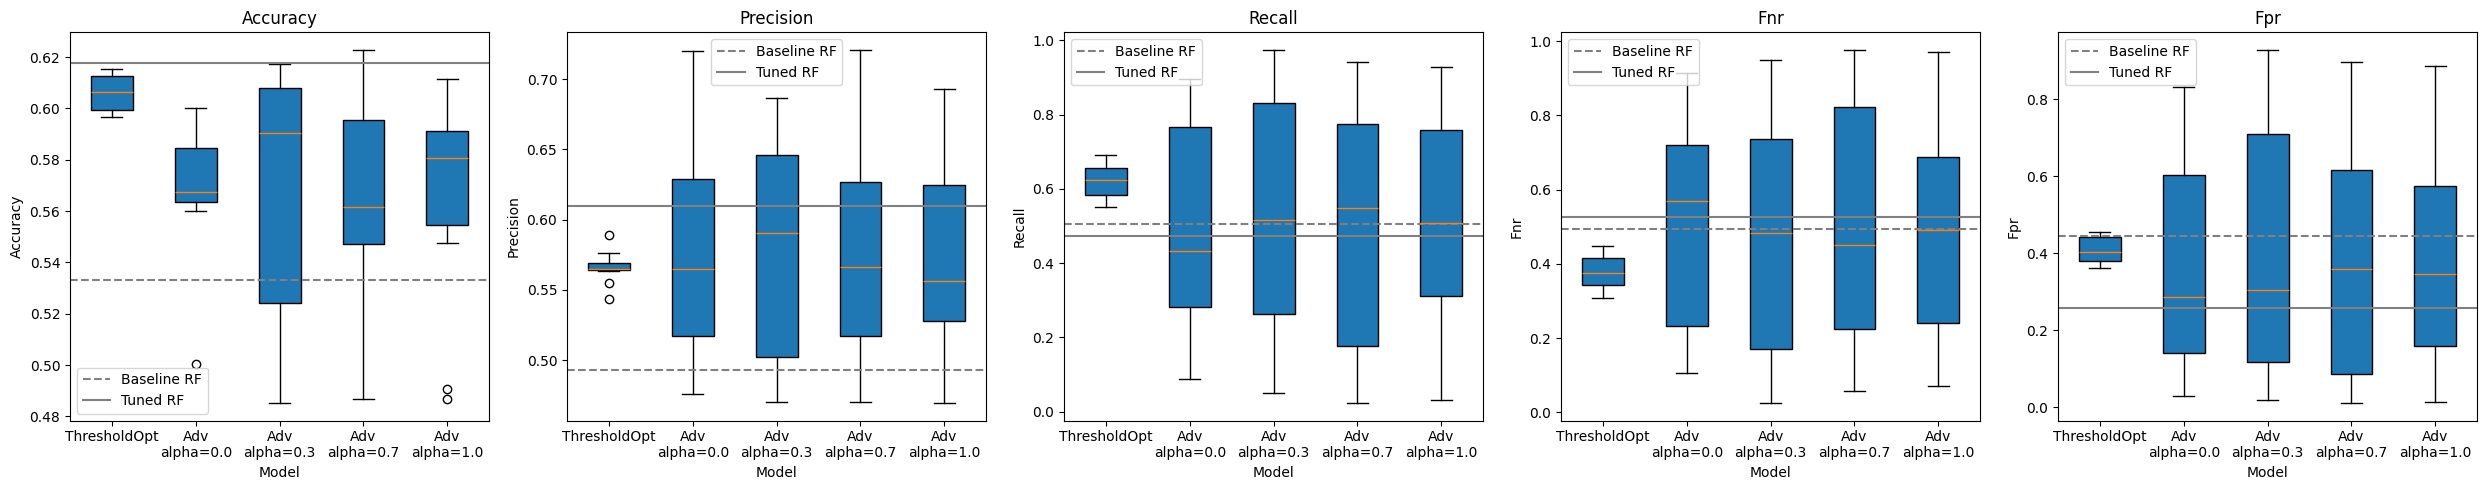

In [37]:
#@markdown Fit the ThresholdOptimizer model here

metrics_to_evaluate = ["Accuracy", "Precision", "Recall", "FNR", "FPR"]

# initializing dictionaries to store results from 10 different splits:
baseline_performance = {metric: [] for metric in metrics_to_evaluate}  # Un-tuned RF (from Part 2(a))
tuned_performance = {metric: [] for metric in metrics_to_evaluate}     # Tuned RF (from Part 2(b))
threshold_performance = {metric: [] for metric in metrics_to_evaluate}  # ThresholdOptimizer

num_splits = 10

# looping through 10 different train/test splits
for split_seed in range(num_splits):
    # generating different train/test splits with unique random states
    X_train_split, X_test_split, y_train_split, y_test_split, sensitive_train_split, sensitive_test_split = train_test_split(
        x_features, y_raw, sensitive_feature, test_size=0.2, random_state=split_seed
    )

    # Baseline Random Forest Model (un-tuned)
    rf_baseline_model = RandomForestClassifier(n_estimators=1, random_state=42)
    rf_baseline_model.fit(X_train_split, y_train_split)
    y_baseline_pred = rf_baseline_model.predict(X_test_split)
    mf_baseline_model = MetricFrame(metrics=metric_dict,
                                     y_true=y_test_split,
                                     y_pred=y_baseline_pred,
                                     sensitive_features=sensitive_test_split)
    for metric in metrics_to_evaluate:
        baseline_performance[metric].append(mf_baseline_model.overall[metric])

    # Tuned Random Forest Model
    rf_tuned_model = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42)
    rf_tuned_model.fit(X_train_split, y_train_split)
    y_tuned_pred = rf_tuned_model.predict(X_test_split)
    mf_tuned_model = MetricFrame(metrics=metric_dict,
                                  y_true=y_test_split,
                                  y_pred=y_tuned_pred,
                                  sensitive_features=sensitive_test_split)
    for metric in metrics_to_evaluate:
        tuned_performance[metric].append(mf_tuned_model.overall[metric])

    # ThresholdOptimizer Post-processing
    thresh_optimizer_model = ThresholdOptimizer(
        estimator=rf_tuned_model,
        constraints="equalized_odds",  # constraint for balancing both FPR and FNR
        predict_method="predict_proba"  # using probability estimates for the threshold
    )
    thresh_optimizer_model.fit(X_train_split, y_train_split, sensitive_features=sensitive_train_split)
    y_thresh_pred = thresh_optimizer_model.predict(X_test_split, sensitive_features=sensitive_test_split)
    mf_thresh_optimizer = MetricFrame(metrics=metric_dict,
                                      y_true=y_test_split,
                                      y_pred=y_thresh_pred,
                                      sensitive_features=sensitive_test_split)
    for metric in metrics_to_evaluate:
        threshold_performance[metric].append(mf_thresh_optimizer.overall[metric])

# computing average metrics across splits for baseline and tuned models
import numpy as np
baseline_avg_results = {metric: np.mean(baseline_performance[metric]) for metric in metrics_to_evaluate}
tuned_avg_results = {metric: np.mean(tuned_performance[metric]) for metric in metrics_to_evaluate}

# the adversarial fairness model results from Part 2(c) are kept in results_df.
# grouping the results by alpha for plotting purposes
adv_model_results = {}
for alpha in alpha_values:
    adv_model_results[alpha] = {}
    for metric in metrics_to_evaluate:
        adv_model_results[alpha][metric] = results_df.loc[results_df["Alpha"] == alpha, metric].values

# plotting
# for each metric, we are creating boxplots:
# box 1: ThresholdOptimizer (post-processing)
# boxes 2-5: Adversarial Fairness Classifier results for alpha = 0.0, 0.3, 0.7, 1.0 (from Part 2(c))
fig, axs = plt.subplots(1, len(metrics_to_evaluate), figsize=(5 * len(metrics_to_evaluate), 5))

# ensuring axs is iterable if only one plot is present
if len(metrics_to_evaluate) == 1:
    axs = [axs]

for i, metric in enumerate(metrics_to_evaluate):
    ax = axs[i]

    # getting data for boxplots:
    # first element: ThresholdOptimizer results (10 values)
    # next four elements: Adversarial fairness results for each alpha value
    box_data = [threshold_performance[metric]]
    for alpha in alpha_values:
        box_data.append(adv_model_results[alpha][metric])

    bp = ax.boxplot(box_data, patch_artist=True)
    ax.set_xticklabels(["ThresholdOpt"] + [f"Adv\nalpha={alpha}" for alpha in alpha_values])
    ax.set_title(metric.capitalize())
    ax.set_xlabel("Model")
    ax.set_ylabel(metric.capitalize())

    # plotting horizontal reference lines (dashed for baseline, solid for tuned RF)
    ax.axhline(y=baseline_avg_results[metric], color='gray', linestyle='--', label="Baseline RF")
    ax.axhline(y=tuned_avg_results[metric], color='gray', linestyle='-', label="Tuned RF")
    ax.legend()

plt.tight_layout()
plt.show()
